In [ ]:
import shap
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from scipy.stats import uniform, randint
from scripts import revalidation as tsvm
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, RandomizedSearchCV

In [30]:
splitter = tsvm.ExpandingWindowSplitter(n_splits=10)

In [57]:
train_df = pd.read_csv('train_set.csv')
test_df = pd.read_csv('test_set.csv')

kaggle_test = pd.read_csv('../competitive-data-science-predict-future-sales/test.csv')

In [32]:

train_df = train_df[train_df['date__month'] > 12].reset_index(drop=True)
X_test = test_df.drop(columns='item_cnt_month')
X_test = X_test.fillna(0)

In [33]:
for col in train_df.select_dtypes(include=['object']).columns:
    train_df[col] = train_df[col].astype('category')

for col in X_test.select_dtypes(include=['object']).columns:
    X_test[col] = X_test[col].astype('category')

In [34]:
X = train_df.drop(columns='item_cnt_month')
y = train_df['item_cnt_month']

In [ ]:
param_distributions = {
    'n_estimators': randint(350, 1000),  
    'learning_rate': uniform(0.01, 0.3), 
    'max_depth': randint(3, 10),  
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),  
    'enable_categorical': [True]
}

model = XGBRegressor(device="cuda",random_state=42, enable_categorical=True, predictor="gpu_predictor")

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=5,  
    cv=splitter,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,  
    random_state=42
)

In [8]:
random_search.fit(X, y, verbose=True)

print("Best param:", random_search.best_params_)
print("Best RMSE:", -random_search.best_score_)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:22:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:22:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Best param: {'colsample_bytree': 0.7468055921327309, 'enable_categorical': True, 'learning_rate': 0.05679835610086079, 'max_depth': 5, 'n_estimators': 808, 'subsample': 0.9598528437324805, 'verbose': 3}
Best RMSE: 4.345734585993285


In [ ]:
final_model = XGBRegressor(**random_search.best_params_)
final_model.fit(X, y)

In [50]:
y_pred = final_model.predict(X_test)

In [ ]:
kaggle_test.drop(columns=['shop_id','item_id'], inplace=True)
kaggle_test['item_cnt_month'] = y_pred
kaggle_test['item_cnt_month'] = kaggle_test['item_cnt_month'].clip(lower=0, upper=70)

In [56]:
kaggle_test.to_csv('test_submission.csv', index=False)

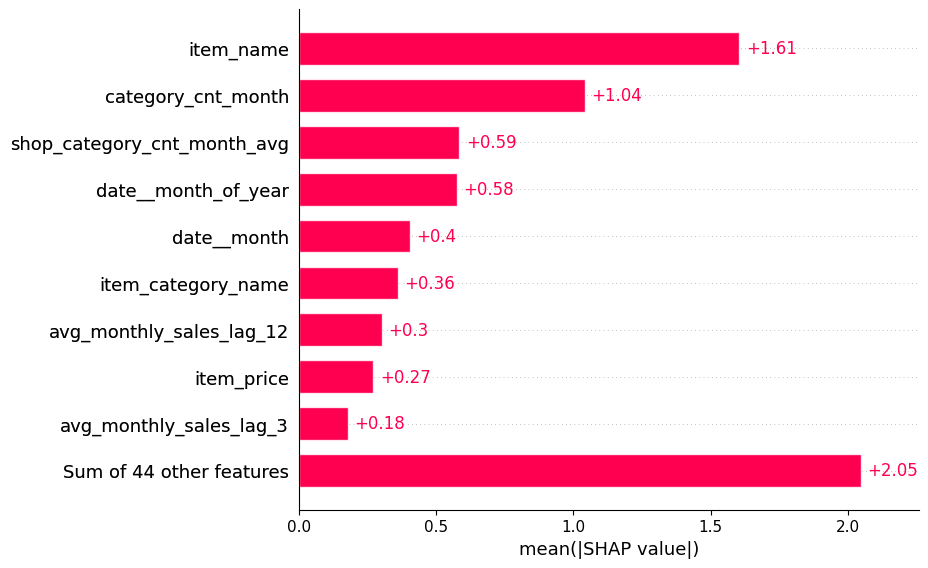

In [ ]:
explainer = shap.Explainer(final_model, feature_perturbation='tree_path_dependent')
shap_values = explainer(X_test)
shap.plots.bar(shap_values)